In [1]:
## Importing required packages and functions.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
import subprocess
import os

In [2]:
## This data obtained from open source at: https://www.kaggle.com/datasets/zaraavagyan/weathercsv?resource=download
## I do not claim ownership of the data, all rights belong to the respective owner(s).

## Downloading the data.
subprocess.run(['kaggle', 'datasets', 'download', '-d', 'zaraavagyan/weathercsv'], check=True)
from zipfile import ZipFile
with ZipFile("weathercsv.zip", 'r') as ZIPPED:
    ZIPPED.extractall("./Assets/")

os.system(f"del weathercsv.zip")

## Loading data
weatherData = pd.read_csv("./Assets/weather.csv") ## importing data


## Dropping NA data rows.
weatherData.dropna(inplace=True)

In [3]:
# ## Firstly visualizing the data, to see what the likely key component interactions are.
# sns.heatmap(weatherData.corr(), annot=False)


In [4]:
## Identifying the categorical features.

categoricalFeatures = [column_name for column_name in weatherData.columns if weatherData[column_name].dtype == 'O']
print("Amount of Categorical Features: {}".format(len(categoricalFeatures)))
print("Categorical Features: ",categoricalFeatures)

Amount of Categorical Features: 5
Categorical Features:  ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [5]:
## Cardinality check.
for each_feature in categoricalFeatures:
   unique_values = len(weatherData[each_feature].unique())
   print("Cardinality(no. of unique values) of {} are: {}".format(each_feature, unique_values))


Cardinality(no. of unique values) of WindGustDir are: 16
Cardinality(no. of unique values) of WindDir9am are: 16
Cardinality(no. of unique values) of WindDir3pm are: 16
Cardinality(no. of unique values) of RainToday are: 2
Cardinality(no. of unique values) of RainTomorrow are: 2


In [6]:
## Dropping high cardinality columns.
weatherData.drop(['WindGustDir','WindDir9am','WindDir3pm'], axis = 1, inplace = True)

In [7]:
## Checking for any NULL values in data, should be 0 as all NA/NULL values were dropped.
categoricalFeatures = [column_name for column_name in weatherData.columns if weatherData[column_name].dtype == 'O']
weatherData[categoricalFeatures].isnull().sum()

numericalFeatures = [column_name for column_name in weatherData.columns if weatherData[column_name].dtype != 'O']
weatherData[numericalFeatures].isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RISK_MM          0
dtype: int64

In [8]:
## Identifying the numerical features.

numericalFeatures = [column_name for column_name in weatherData.columns if weatherData[column_name].dtype != 'O']
print("Amount of Numerical Features: {}".format(len(numericalFeatures)))
print("Numerical Features: ",numericalFeatures)

Amount of Numerical Features: 17
Numerical Features:  ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RISK_MM']


In [9]:
## Feature encoding.

weatherData['RainToday'].replace({'No':0, 'Yes': 1}, inplace = True)

weatherData['RainTomorrow'].replace({'No':0, 'Yes': 1}, inplace = True)

C:\Users\willi\AppData\Local\Temp\ipykernel_276808\4267388211.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weatherData['RainToday'].replace({'No':0, 'Yes': 1}, inplace = True)
C:\Users\willi\AppData\Local\Temp\ipykernel_276808\4267388211.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wea

<Axes: >

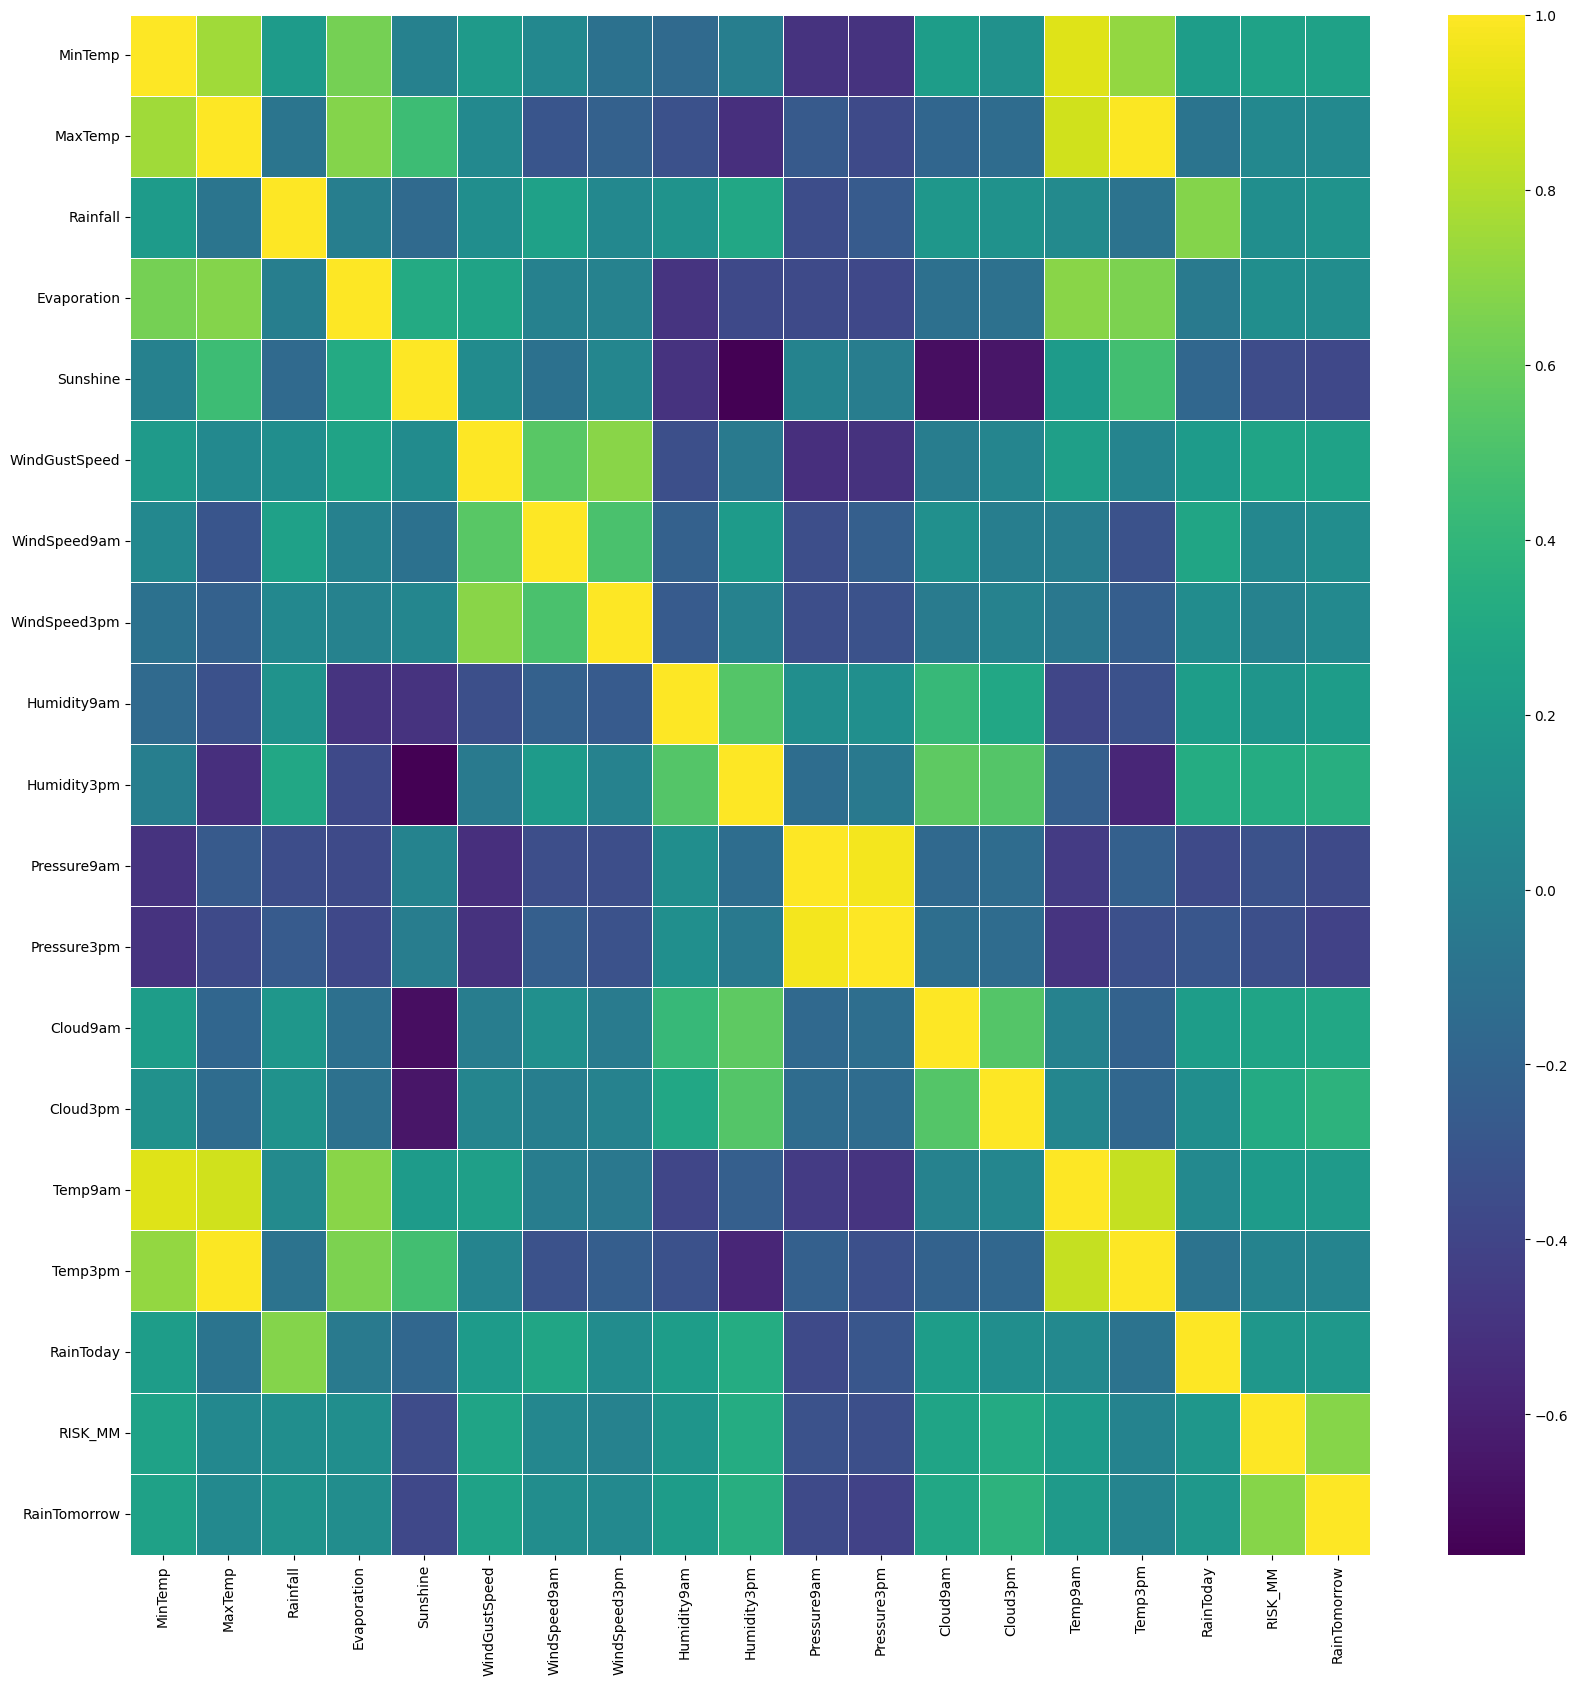

In [10]:
## Assessing the correlation between the various parameters.
plt.figure(figsize=(20,20))
sns.heatmap(weatherData.corr(), linewidths=0.5, annot=False, fmt=".2f", cmap = 'viridis')

<Axes: >

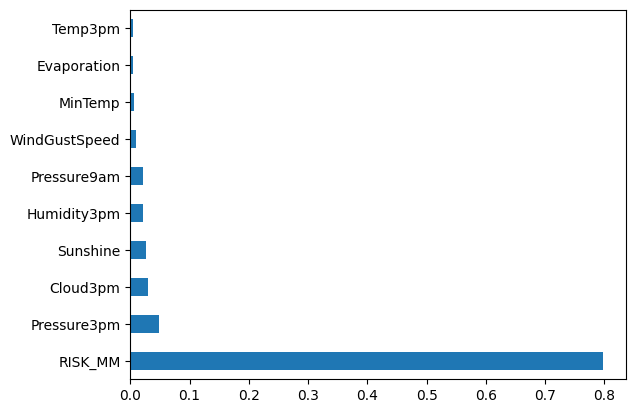

In [11]:
## Quantifying feature importance.

X = weatherData.drop(['RainTomorrow'],axis=1)
y = weatherData['RainTomorrow']
etr_model = ExtraTreesRegressor()
etr_model.fit(X,y)
etr_model.feature_importances_

## Visualizing the feature importance.
feature_imp = pd.Series(etr_model.feature_importances_,index=X.columns)
feature_imp.nlargest(10).plot(kind='barh')

In [12]:
## Making training models.
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)
print("Length of Training Data: {}".format(len(X_train)))
print("Length of Testing Data: {}".format(len(X_test)))

Length of Training Data: 262
Length of Testing Data: 66


# KN classifier

In [13]:
## Making KN model to include: PCA analysis, feature scaling, and the KN model itself.
KNC_Pipeline = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        PCA(),
        KNeighborsClassifier(n_neighbors=10)
    ),
    {
        "pca__n_components" : range(1, 10),
    }
)

## Fitting the model and viewing the score.
KNC_Pipeline.fit(X_train, y_train)
print(f"Score for K-Neighbors Classifier is: {KNC_Pipeline.score(X_test, y_test):.3}")
print(f"From PCA analysis, the best estimator is: {KNC_Pipeline.best_estimator_['pca'].n_components_}")


Score for K-Neighbors Classifier is: 0.894
From PCA analysis, the best estimator is: 6


Accuracy Score: 0.894


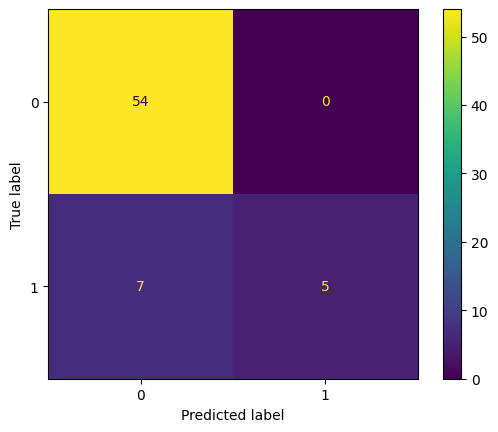

In [14]:
## Testing the KN model by predicting values.
y_PredictionKNC = KNC_Pipeline.predict(X_test)

## Assessing the KN model score.
print("Accuracy Score: {:.3}".format(accuracy_score(y_test,y_PredictionKNC)))

## Visualizing with a confusion matrix.
cm = confusion_matrix(y_test, y_PredictionKNC)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [15]:
## Checking the KN model for over/under fitting.
print("Train Data Score: {}".format(KNC_Pipeline.score(X_train, y_train)))
print("Test Data Score: {}".format(KNC_Pipeline.score(X_test, y_test)))

## Checking if score can be improved for KN classifier.
from sklearn.model_selection import cross_val_score
scores = cross_val_score(KNC_Pipeline, X_train, y_train, cv = 5, scoring='accuracy')
print('Cross-validation scores:{}'.format(scores))
print('Average cross-validation score: {}'.format(scores.mean()))

Train Data Score: 0.8816793893129771
Test Data Score: 0.8939393939393939
Cross-validation scores:[0.86792453 0.81132075 0.84615385 0.88461538 0.86538462]
Average cross-validation score: 0.8550798258345427


In [16]:
## Saving out the trained KN classifier.

with open('./Classifiers/KNC_Rain.pkl', 'wb') as file:
    pickle.dump(KNC_Pipeline, file)

# SVC classifier

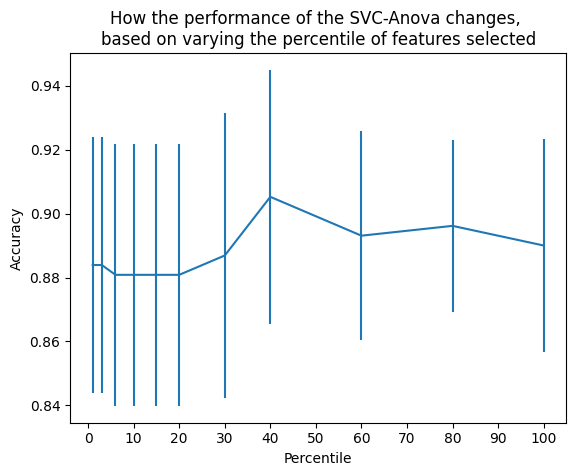

In [17]:
## Checking to see how many features should be kept.
SVC_CheckPipeline = Pipeline(
    [   
        ("scaler", MinMaxScaler()),
        ("anova", SelectPercentile(chi2)),
        ("svc", SVC(gamma="auto",random_state = 42,decision_function_shape='ovr',kernel="linear"),),
    ]
)
scoremeans = list()
scoreSTDs = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

## Looping over each percentile and checking the accuracy.
for percentile in percentiles:
    SVC_CheckPipeline.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(SVC_CheckPipeline, X, y)
    scoremeans.append(this_scores.mean())
    scoreSTDs.append(this_scores.std())

## Outputting the accuracies as a graph.
plt.errorbar(percentiles, scoremeans, np.array(scoreSTDs))
plt.title("How the performance of the SVC-Anova changes, \nbased on varying the percentile of features selected")
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel("Percentile")
plt.ylabel("Accuracy")
plt.axis("tight")
plt.show()


Score for SVC Classifier is: 0.944
From PCA analysis, the best estimator is: 7


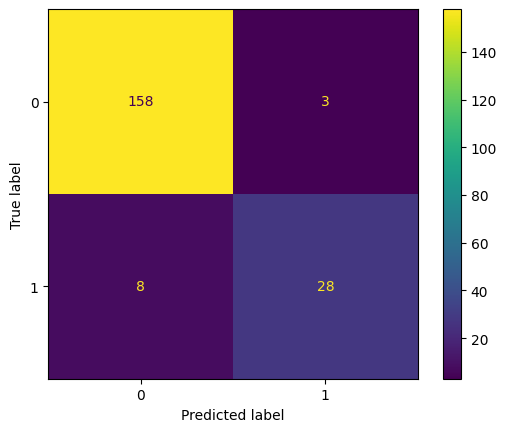

In [18]:
## Taking 40% of features, as this was the highest accuracy based on the graph made in the previous step.
## Also re-making weatherData to incorporate this change.

featureSelection = VarianceThreshold(0.4)
featureSelection.fit_transform(weatherData)

X = weatherData.drop(['RainTomorrow'],axis=1)
y = weatherData['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.6, random_state = 0)

SVC_Pipeline = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        PCA(),
        SVC(gamma=10,random_state = 42,decision_function_shape='ovr',kernel="linear",tol=0.1,C=0.5),
    ),
    {
        "pca__n_components" : range(1, 8),
    }
)


SVC_Pipeline.fit(X_train, y_train)
print(f"Score for SVC Classifier is: {SVC_Pipeline.score(X_test, y_test):.3}")
print(f"From PCA analysis, the best estimator is: {SVC_Pipeline.best_estimator_['pca'].n_components_}")

## Checking correct and incorrect predictions with a confusion matrix.
y_Prediction = SVC_Pipeline.predict(X_test)
confusionMatrix_SVC = confusion_matrix(y_test, y_Prediction)
cm_display = ConfusionMatrixDisplay(confusionMatrix_SVC).plot()

In [19]:
## Checking for over/under fitting.
print("Train Data Score: {}".format(SVC_Pipeline.score(X_train, y_train)))
print("Test Data Score: {}".format(SVC_Pipeline.score(X_test, y_test)))

## Checking if score can be improved for KN classifier.
from sklearn.model_selection import cross_val_score
scores = cross_val_score(SVC_Pipeline, X_train, y_train, cv = 5, scoring='accuracy')
print('Cross-validation scores:{}'.format(scores))
print('Average cross-validation score: {}'.format(scores.mean()))

Train Data Score: 0.9770992366412213
Test Data Score: 0.9441624365482234
Cross-validation scores:[1.         1.         0.96153846 0.76923077 0.92307692]
Average cross-validation score: 0.9307692307692308


In [20]:
## Saving out the trained classifier.

with open('./classifiers/SVC_Rain.pkl', 'wb') as file:
    pickle.dump(SVC_Pipeline, file)

---
# Conclusions

SVC was found to be the better model, with a score of 0.944 vs KN with a score of 0.894.